In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds

from delfi.simulator.BaseSimulator import BaseSimulator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

from delfi.utils.viz import plot_pdf

from tqdm import tqdm_notebook as tqdm

%matplotlib notebook

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
class SphereModel(BaseSimulator):
    def __init__(self, sigma, ndim, seed=None):
        super().__init__(dim_param=ndim, seed=seed)
        
        self.sigma = sigma
        
    def gen_single(self, params):
        m = np.linalg.norm(params)
        draw = self.rng.normal(loc=m, scale=self.sigma, size=(1,))
        return { 'data' : draw }
    
class SphericalDistribution(dd.BaseDistribution.BaseDistribution):
    def __init__(self, sm, obs_stats, seed=None):
        super().__init__(sm.dim_param, seed=seed)
        self.sm = sm
        self.obs_stats = obs_stats
        self.m = np.linalg.norm(obs_stats)
        self.sigma = sm.sigma
        
    def eval(self, params, log=True):
        logl = -0.5 * np.log(2 * np.pi * self.sigma) -0.5 * (np.linalg.norm(params, axis=1) - self.m) ** 2 / (self.sigma ** 2)
        return logl if log else np.exp(logl)

In [12]:
seed = 678
ndim = 2
n_components = 8
n_hiddens = n_components * ndim * 5

sigma = 0.2

true_params = 2 * np.eye(ndim)[0]
obs_stats = [np.linalg.norm(true_params)]

n_train = 600
n_rounds = 5

nprocs = 3

In [13]:
ms = [ SphereModel(sigma=sigma, ndim=ndim, seed=seed) for i in range(nprocs) ]
p = dd.Uniform(-2 * np.ones(ndim), 2 * np.ones(ndim), seed=seed)
s = ds.Identity(1)
g = dg.MPGenerator(models=ms, prior=p, summary=s)

gt = SphericalDistribution(ms[0], obs_stats, seed=seed)

print(gt.eval([obs_stats]))

[0, 1, 2, 3]
[0, 1, 2, 3]
[-0.11421958]
[0, 1, 2, 3]


In [14]:
res = infer.SNPE(g, obs=[obs_stats], n_hiddens=[n_hiddens], n_components=n_components, seed=seed, verbose=True)
logs, tds, posteriors = res.run(n_train=n_train, n_rounds = n_rounds, round_cl=3)

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

HBox(children=(IntProgress(value=0, max=60000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

HBox(children=(IntProgress(value=0, max=60000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

HBox(children=(IntProgress(value=0, max=60000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

HBox(children=(IntProgress(value=0, max=60000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

HBox(children=(IntProgress(value=0, max=60000), HTML(value='')))

In [15]:
def plot_pdfs_2d(dists, labels = None):
    lims = 2 * np.linalg.norm(obs_stats)
    xlist = np.linspace(-lims, lims, 80)
    ylist = np.linspace(-lims, lims, 80)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    
    X, Y = np.meshgrid(xlist, ylist)
    xys = np.asarray((X.ravel(), Y.ravel())).T
    
    for i in range(len(dists)):
        d = dists[i]
        Z = d.eval(xys, log=False).reshape(X.shape)
        if labels:
            ax.plot_surface(X, Y, Z, label=labels[i], 
                            cmap=cm.plasma, rstride=1, cstride=1, linewidth=0, antialiased=False)
        else:
            ax.plot_surface(X, Y, Z, 
                            cmap=cm.plasma, rstride=1, cstride=1, linewidth=0, antialiased=False)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #if labels:
    #    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    ax.set_xlabel("$\\theta_1$")
    ax.set_xlabel("$\\theta_2$")
    ax.set_zlabel("$p(\\theta)$")
    plt.show()
    
    return fig

<IPython.core.display.Javascript object>


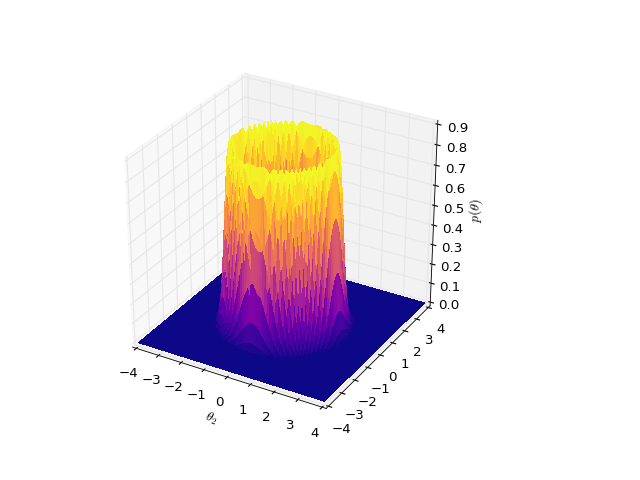

<IPython.core.display.Javascript object>


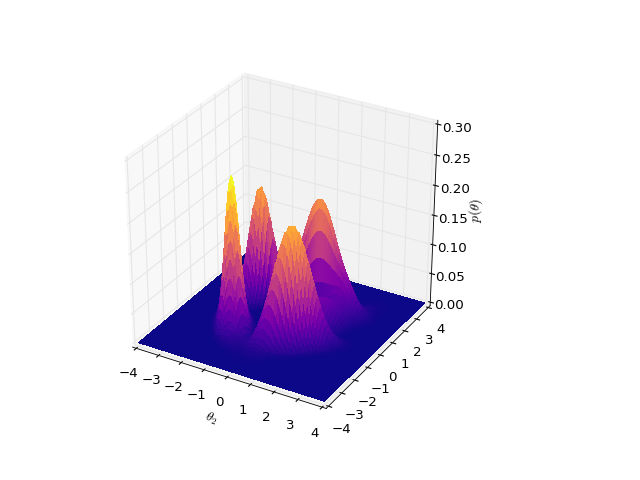

<IPython.core.display.Javascript object>


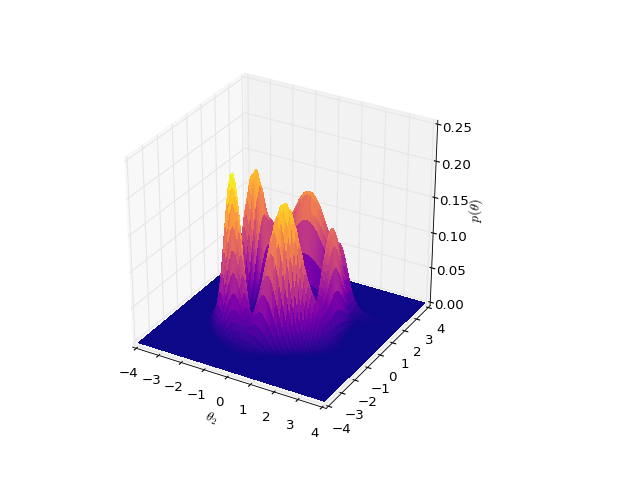

<IPython.core.display.Javascript object>


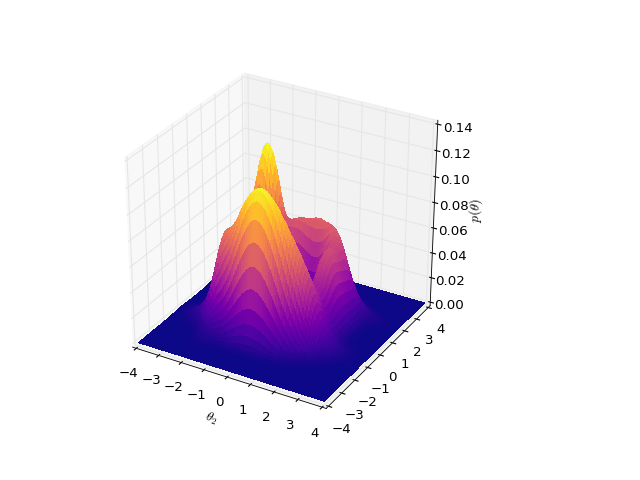

<IPython.core.display.Javascript object>


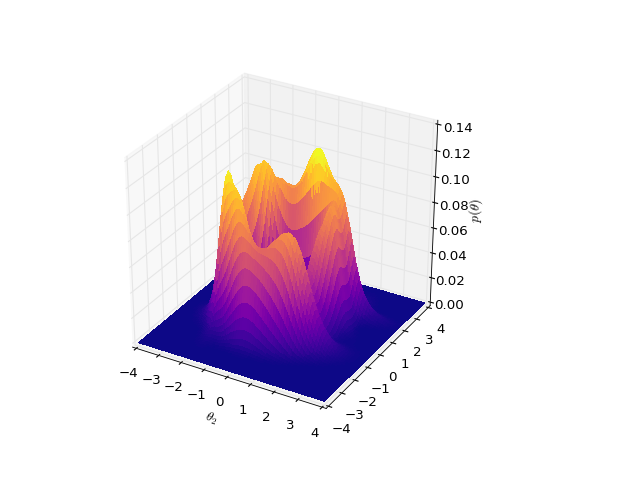

<IPython.core.display.Javascript object>


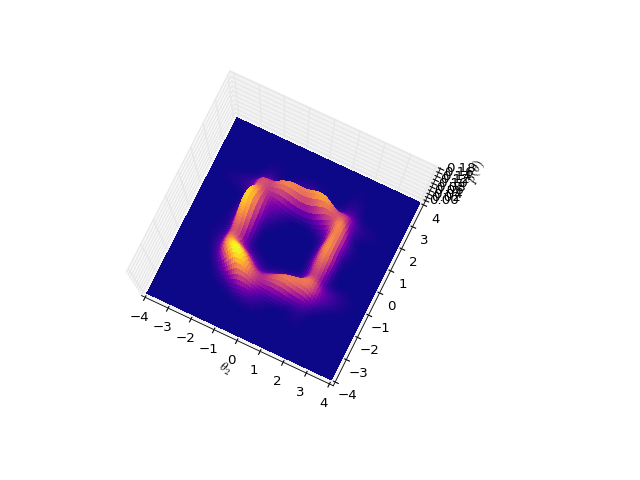

In [16]:
plot_pdfs_2d([gt]);

for p in posteriors:
    plot_pdfs_2d([p]);

In [21]:
def plot_pdfs_1d(dists, labels = None):
    lims = 2
    xlist = np.linspace(-lims, lims, 200)
    
    fig, ax = plt.subplots(1, figsize=(12, 3))
    
    for i in range(len(dists)):
        d = dists[i]
        ylist = d.eval(xlist.reshape((-1,1)), log=False)
        if labels:
            ax.plot(xlist, ylist, label=labels[i])
        else:
            ax.plot(xlist, ylist)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    if labels:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    ax.set_xlabel("$\\theta$")
    ax.set_ylabel("$p(\\theta)$")
    plt.show()
    
    return fig

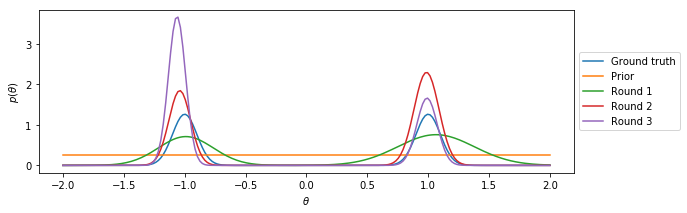

In [149]:
plot_pdfs_1d([gt, p] + posteriors, ["Ground truth", "Prior"] + [ "Round {}".format(i + 1) for i in range(n_rounds) ]);